# 1.2 a) Visualize the optimization process.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)


In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
    return train_loader

def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

print("Train_dataset size:", len(train_dataset),"\nTest_dataset size:", len(test_dataset))

Train_dataset size: 60000 
Test_dataset size: 10000


In [3]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('started')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            prediction = model(images)
            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        for name, parameter in model.named_parameters():
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss
     

In [5]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [6]:
max_epochs = 30
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0002,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt], ignore_index=True)
    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr
     

Time: 0
started
Time: 1y of the network on the test images: 97.19% & Test Loss: 0.09281539544463158
started
Time: 2y of the network on the test images: 97.12% & Test Loss: 0.0990191750228405
started
Time: 3y of the network on the test images: 97.0% & Test Loss: 0.100449188798666
started
Time: 4y of the network on the test images: 97.12% & Test Loss: 0.09678149372339248
started
Time: 5y of the network on the test images: 97.26% & Test Loss: 0.09338565543293953
started
Time: 6y of the network on the test images: 97.23% & Test Loss: 0.09386177230626344
started
Time: 7y of the network on the test images: 97.04% & Test Loss: 0.09805064126849175
started


In [12]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])
print(all_df)
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = all_df
print(pd.DataFrame(t1))

              0             1             2             3             4    \
0    1.748428e-02 -3.643958e-04  5.497875e-03  6.346869e-06  4.730536e-05   
1    9.235719e-03  1.078450e-05  9.246279e-04 -5.016550e-07  2.518564e-06   
2    4.151181e-03  7.472493e-07  4.903737e-05  2.052048e-08  3.101327e-09   
3    1.564623e-03 -4.997273e-08 -1.395133e-06 -9.733966e-10 -4.434934e-09   
4    4.911066e-04 -2.006579e-09 -1.196437e-08  1.368816e-11  2.134083e-10   
..            ...           ...           ...           ...           ...   
235 -1.279839e-29 -7.947436e-40 -2.368519e-38 -4.053281e-38  9.611934e-36   
236  5.236417e-31 -7.947436e-40 -2.368519e-38 -1.923343e-38  3.542278e-37   
237 -1.138815e-32 -7.947436e-40 -2.368519e-38 -1.923343e-38 -1.252804e-38   
238 -4.097250e-34 -7.947436e-40 -2.368519e-38 -1.923343e-38 -1.252804e-38   
239  7.086223e-35 -7.947436e-40 -2.368519e-38 -1.923343e-38 -1.252804e-38   

              5             6             7             8             9    

In [13]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)
    itrData = np.full((pcaVal.shape[0],1),itr)
    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf

In [14]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
print(epoch3Df)

            x         y  Epoch  Iteration        Acc      Loss
0    5.375694  2.385643      0          0  33.861445  1.740279
1    6.642767  2.931668      1          0  82.955129  0.692817
2    7.388725  3.262196      2          0  88.271317  0.419865
3    7.921731  3.500775      3          0  90.326108  0.338610
4    8.351595  3.691927      4          0  91.646955  0.295383
..        ...       ...    ...        ...        ...       ...
235 -3.698381 -5.050765     25          7  97.424987  0.087495
236 -3.696678 -5.046556     26          7  97.665960  0.084108
237 -3.695796 -5.044141     27          7  97.786623  0.081126
238 -3.693208 -5.040688     28          7  97.868424  0.077604
239 -3.692414 -5.035863     29          7  97.982265  0.074508

[240 rows x 6 columns]
            x         y  Epoch  Iteration        Acc      Loss
0    7.388725  3.262196      2          0  88.271317  0.419865
1    8.710108  3.849814      5          0  92.425957  0.266176
2    9.508209  4.206992      8 

In [15]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))


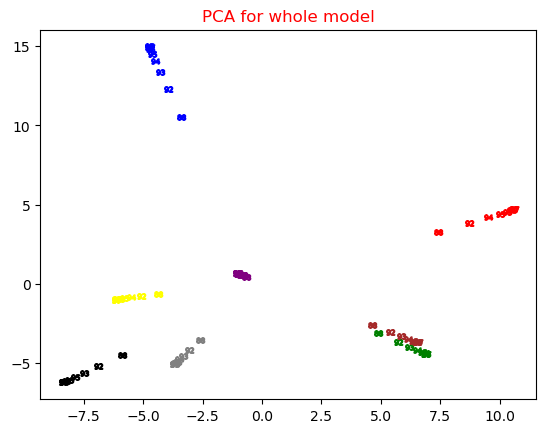

<Figure size 5000x2500 with 0 Axes>

In [16]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for whole model",color="r")
    
plt.figure(figsize=[10,5],dpi=500)
plt.show()

            x         y  Epoch  Iteration        Acc      Loss
0   -0.402965  0.403767      0          0  33.861445  1.740279
1   -0.524997  0.510036      1          0  82.955129  0.692817
2   -0.604255  0.583273      2          0  88.271317  0.419865
3   -0.659958  0.636482      3          0  90.326108  0.338610
4   -0.720845  0.687050      4          0  91.646955  0.295383
..        ...       ...    ...        ...        ...       ...
235 -0.214631 -0.635271     25          7  97.424987  0.087495
236 -0.215318 -0.630923     26          7  97.665960  0.084108
237 -0.213832 -0.625665     27          7  97.786623  0.081126
238 -0.214297 -0.622087     28          7  97.868424  0.077604
239 -0.214486 -0.616320     29          7  97.982265  0.074508

[240 rows x 6 columns]


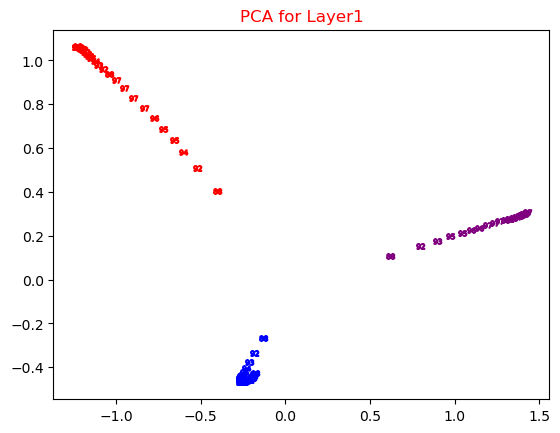

In [17]:
layer1_Df = all_df.iloc[:,0:7840]
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data
print(layer1Df)
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="r")
plt.show()

In [18]:
torch.manual_seed(1) 
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  
y = (np.sin(5*np.pi*x))/(5*np.pi*x) 
print('Xshape:',x.shape,"\n Yshape:",y.shape)

x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
n_samples, n_features = x.shape

Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


/local_scratch/slurm.712690/ipykernel_3318801/844140679.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [19]:
class M1(nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
def trainFunc(model,x,y):
    max_epoch = 2500
    epoch_arr,loss_arr=[],[]
    not_converged = True
    epoch = 0
    gradArr = []
    while not_converged:
        epoch += 1
        prediction = model(x)     
        loss = loss_func(prediction, y)     
        optimizer.zero_grad()   
        loss.backward()         
        
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        

        optimizer.step() 
        
        gradArr.append(grad_norm)
        
        if epoch%100 == 0 : print(f'epoch: {epoch}, loss = {loss.item():.4f}, grad_norm = {grad_norm}') 
                
        if epoch == max_epoch:
                print("Max Epoch Reached")
                not_converged = False
        elif (epoch > 5) and  (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print("Convergeance reached for loss:",loss_arr[-1])
                not_converged = False
                
    return epoch_arr,loss_arr,prediction,grad_norm,gradArr

In [21]:
torch.manual_seed(1)
m1 = M1()     
optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss() 

a=[]
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total number of parameters in Model (1):', np.sum(a),)
M1epoch_arr,M1loss_arr,M1prediction,M1grad_norm,M1gradArr = trainFunc(m1,x,y)

Total number of parameters in Model (1): 1501
epoch: 100, loss = 0.0518, grad_norm = 0.04283318368227245
epoch: 200, loss = 0.0310, grad_norm = 0.03160978463406819
epoch: 300, loss = 0.0158, grad_norm = 0.020891545870852447
epoch: 400, loss = 0.0092, grad_norm = 0.012171428311993141
epoch: 500, loss = 0.0066, grad_norm = 0.007926769205638116
epoch: 600, loss = 0.0053, grad_norm = 0.005783667578245152
epoch: 700, loss = 0.0045, grad_norm = 0.0047853965918377385
epoch: 800, loss = 0.0038, grad_norm = 0.004264117367846688
epoch: 900, loss = 0.0032, grad_norm = 0.0046597535463634675
epoch: 1000, loss = 0.0027, grad_norm = 0.00405081146312055
epoch: 1100, loss = 0.0023, grad_norm = 0.004377674298856849
epoch: 1200, loss = 0.0020, grad_norm = 0.015536987059095514
epoch: 1300, loss = 0.0017, grad_norm = 0.0031101834715484404
epoch: 1400, loss = 0.0015, grad_norm = 0.002504985719799162
epoch: 1500, loss = 0.0014, grad_norm = 0.002244380396155892
epoch: 1600, loss = 0.0012, grad_norm = 0.007056

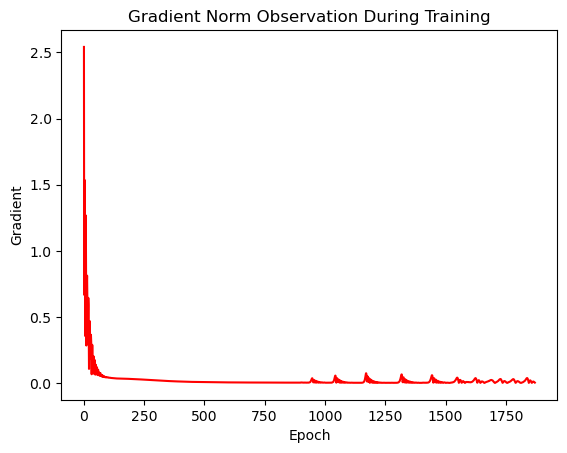

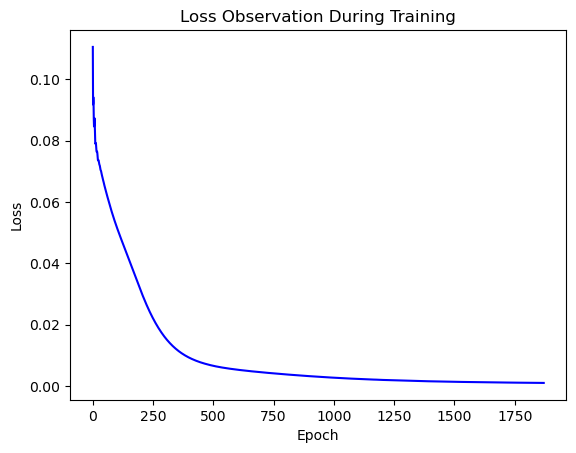

In [22]:
plt.plot(M1epoch_arr,M1gradArr,color="Red")
plt.title('Gradient Norm Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient")
plt.show()

plt.plot(M1epoch_arr,M1loss_arr,color="Blue")
plt.title('Loss Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Gradient is almost zero


In [23]:
!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

Defaulting to user installation because normal site-packages is not writeable


In [24]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [25]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 
        loss = loss_fn(out, targets)    
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 
        loss = loss_fn(out, targets)    
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 
        loss = loss_fn(out, targets)    
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [26]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        
        h_eig = torch.linalg.eigvalsh(h, UPLO='U') 
        
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio)

    return ratio_mean


In [27]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [28]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    return history,grad_norm_per_epoch,model

In [31]:
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"

In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()

In [33]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)
           

In [34]:
result_1 = evaluate(model,criterion,data_loader)


/home/gauravp/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [35]:
train,target = X,Y


In [36]:
class M1(torch.nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)    
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)     
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)                    
        return x

model_1 = M1()     

In [37]:
history_1,grad_norm_1,model  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)


gradient norm: 0.8235280029475689, minimum ratio: 0.6875
Epoch [0], val_loss: 0.1185
gradient norm: 0.8915635161101818, minimum ratio: 0.71875
Epoch [1], val_loss: 0.1240
gradient norm: 0.9603039901703596, minimum ratio: 0.73046875
Epoch [2], val_loss: 0.1298
gradient norm: 1.0295406244695187, minimum ratio: 0.6953125
Epoch [3], val_loss: 0.1361
gradient norm: 1.0992021076381207, minimum ratio: 0.71484375
Epoch [4], val_loss: 0.1429
gradient norm: 1.169234350323677, minimum ratio: 0.7265625
Epoch [5], val_loss: 0.1502
gradient norm: 1.2396116945892572, minimum ratio: 0.70703125
Epoch [6], val_loss: 0.1580
gradient norm: 1.3102730941027403, minimum ratio: 0.7109375
Epoch [7], val_loss: 0.1662
gradient norm: 1.3811864703893661, minimum ratio: 0.703125
Epoch [8], val_loss: 0.1749
gradient norm: 1.4523267354816198, minimum ratio: 0.73046875
Epoch [9], val_loss: 0.1840
gradient norm: 1.5236770026385784, minimum ratio: 0.7265625
Epoch [10], val_loss: 0.1936
gradient norm: 1.5952204205095768,

In [38]:
grad_norm_1


{0: {'grad_norm': 0.8235280029475689, 'ratio': 0.6875},
 1: {'grad_norm': 0.8915635161101818, 'ratio': 0.71875},
 2: {'grad_norm': 0.9603039901703596, 'ratio': 0.73046875},
 3: {'grad_norm': 1.0295406244695187, 'ratio': 0.6953125},
 4: {'grad_norm': 1.0992021076381207, 'ratio': 0.71484375},
 5: {'grad_norm': 1.169234350323677, 'ratio': 0.7265625},
 6: {'grad_norm': 1.2396116945892572, 'ratio': 0.70703125},
 7: {'grad_norm': 1.3102730941027403, 'ratio': 0.7109375},
 8: {'grad_norm': 1.3811864703893661, 'ratio': 0.703125},
 9: {'grad_norm': 1.4523267354816198, 'ratio': 0.73046875},
 10: {'grad_norm': 1.5236770026385784, 'ratio': 0.7265625},
 11: {'grad_norm': 1.5952204205095768, 'ratio': 0.72265625},
 12: {'grad_norm': 1.666943646967411, 'ratio': 0.71875},
 13: {'grad_norm': 1.7388440147042274, 'ratio': 0.72265625},
 14: {'grad_norm': 1.8109008111059666, 'ratio': 0.73046875},
 15: {'grad_norm': 1.883105468004942, 'ratio': 0.7265625},
 16: {'grad_norm': 1.9554706551134586, 'ratio': 0.7070

In [39]:
val_losses_1 = [r['val_loss'] for r in history_1]
len(val_losses_1)


2000

In [40]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]


[]

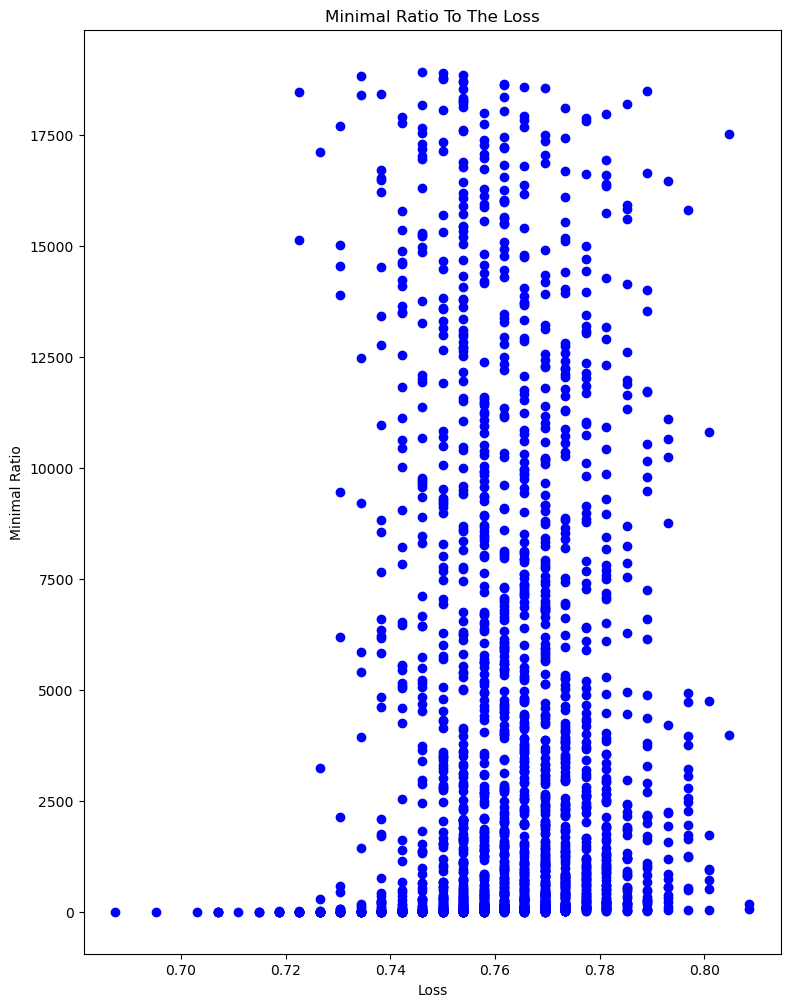

In [41]:
plt.figure(figsize=(9,12))
plt.scatter(minimal_ratio_eps,val_losses_1,color = 'Blue')
plt.xlabel('Loss')
plt.ylabel('Minimal Ratio')
plt.title('Minimal Ratio To The Loss');
plt.plot()